#importing the library

In [ ]:
import glob  # to return all file paths that match a specific pattern

import tensorflow as tf
import numpy as np
from tensorflow import keras
import cv2

import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

import keras
from google.colab import files

from sklearn.metrics import confusion_matrix, classification_report


#get the files of train and test

In [ ]:
!unzip '/content/drive/MyDrive/my projects/shai-level-trainingg.zip'

Archive:  /content/drive/MyDrive/my projects/shai-level-trainingg.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'

#pre-processing

In [ ]:
image_size = 300
Batch_size = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip=True,
    validation_split=0.1
)


#training and validation set

In [ ]:
train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=Batch_size,
    subset='training'
)

val_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=Batch_size,
    subset='validation'
)

Found 1078 images belonging to 3 classes.
Found 118 images belonging to 3 classes.


In [ ]:
train_dataset.class_indices

{'covid': 0, 'normal': 1, 'virus': 2}

#build the model

In [ ]:
cnn = tf.keras.Sequential()

cnn.add(tf.keras.layers.Conv2D(filters=64, padding='same', strides=2,kernel_size=3, activation='relu', input_shape=(300,300,3)))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))


cnn.add(tf.keras.layers.Conv2D(filters=32, padding='same', strides=2,kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# cnn.add(tf.keras.layers.Conv2D(filters=64, padding='same', strides=2,kernel_size=3, activation='relu'))
# cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# cnn.add(tf.keras.layers.Conv2D(filters=128, padding='same', strides=2,kernel_size=3, activation='relu'))
# cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
cnn.compile(tf.keras.optimizers.Adam(clipnorm=1.0),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 175, 175, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 87, 87, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 44, 44, 32)        18464     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 15488)             0         
                                                                 
 dense_4 (Dense)             (None, 3)                

**Training**

In [ ]:
#Learning rate scheduling (by callback)
#Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training (to enhance the model)
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
history = cnn.fit(
      train_dataset,
      epochs=20,
      validation_data=val_dataset,
      callbacks=[callback]  
)

Epoch 1/20
34/34 [==============================] - 85s 2s/step - loss: 0.8405 - accuracy: 0.6104 - val_loss: 0.8417 - val_accuracy: 0.6356 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - 81s 2s/step - loss: 0.5397 - accuracy: 0.7774 - val_loss: 0.6343 - val_accuracy: 0.7203 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - 81s 2s/step - loss: 0.4135 - accuracy: 0.8302 - val_loss: 0.4810 - val_accuracy: 0.8220 - lr: 0.0010
Epoch 4/20
34/34 [==============================] - 79s 2s/step - loss: 0.3735 - accuracy: 0.8571 - val_loss: 0.3610 - val_accuracy: 0.8729 - lr: 0.0010
Epoch 5/20
34/34 [==============================] - 83s 2s/step - loss: 0.3513 - accuracy: 0.8683 - val_loss: 0.4098 - val_accuracy: 0.8475 - lr: 0.0010
Epoch 6/20
34/34 [==============================] - 79s 2s/step - loss: 0.2926 - accuracy: 0.8961 - val_loss: 0.5542 - val_accuracy: 0.8220 - lr: 0.0010
Epoch 7/20
34/34 [==============================] - 81s 2s/step - loss: 0.2823 - a

In [ ]:
type(train_dataset)

keras.preprocessing.image.DirectoryIterator

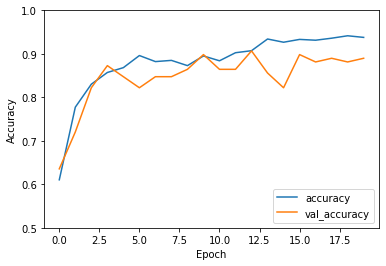

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right') 

#feature extraction

In [ ]:
feature_extractor = keras.Model(
    inputs = cnn.inputs,
    outputs = [layer.output for layer in cnn.layers]
)

In [ ]:
x = tf.ones((1,250,250,3))
features = feature_extractor(x)

In [ ]:
features[0]

<tf.Tensor: shape=(1, 125, 125, 64), dtype=float32, numpy=
array([[[[0.        , 0.01121285, 0.00841435, ..., 1.023357  ,
          0.00330275, 0.0125383 ],
         [0.        , 0.01121285, 0.00841435, ..., 1.023357  ,
          0.00330275, 0.0125383 ],
         [0.        , 0.01121285, 0.00841435, ..., 1.023357  ,
          0.00330275, 0.0125383 ],
         ...,
         [0.        , 0.01121285, 0.00841435, ..., 1.023357  ,
          0.00330275, 0.0125383 ],
         [0.        , 0.01121285, 0.00841435, ..., 1.023357  ,
          0.00330275, 0.0125383 ],
         [0.03244157, 0.20869194, 0.        , ..., 0.6566032 ,
          0.        , 0.        ]],

        [[0.        , 0.01121285, 0.00841435, ..., 1.023357  ,
          0.00330275, 0.0125383 ],
         [0.        , 0.01121285, 0.00841435, ..., 1.023357  ,
          0.00330275, 0.0125383 ],
         [0.        , 0.01121285, 0.00841435, ..., 1.023357  ,
          0.00330275, 0.0125383 ],
         ...,
         [0.        , 0.01121

In [ ]:
type(features[0])

tensorflow.python.framework.ops.EagerTensor

#test

In [ ]:
test=[]
def create_testing_data():
        for img in os.listdir(test_dir):
            try:
                img_arr=cv2.imread(os.path.join(test_dir,img))
                newarr=cv2.resize(img_arr,(300,300))
                test.append([newarr])
            except Exception as e :
                pass
        
create_testing_data()  

In [ ]:
print(len(test))

513


In [ ]:
test_set = np.array(test).reshape(-1,300,300,3)

In [ ]:
test_set = test_set/255

In [ ]:
test_set.shape

(513, 350, 350, 3)

In [ ]:
test_set[0].shape

(350, 350, 3)

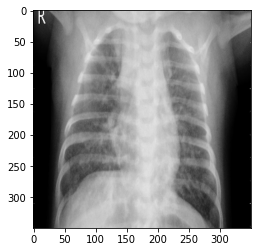

In [ ]:
plt.imshow(test_set[0], cmap='gray')


**Prediction**

In [ ]:
predictions = np.argmax(cnn.predict(test_set), axis=1)


In [ ]:
predictions

array([2, 1, 0, 1, 2, 1, 2, 1, 1, 1, 2, 2, 0, 1, 2, 1, 2, 2, 2, 2, 0, 2,
       0, 0, 2, 1, 1, 1, 0, 0, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1, 2, 1,
       0, 2, 1, 2, 1, 0, 1, 1, 0, 0, 2, 1, 1, 1, 2, 1, 0, 2, 2, 1, 2, 0,
       2, 1, 0, 0, 1, 2, 1, 2, 0, 2, 1, 2, 1, 1, 2, 0, 2, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 1, 2, 1, 2, 2, 0, 1, 2, 1, 1, 0, 2, 0, 0, 1, 1, 1, 1,
       2, 1, 2, 2, 1, 2, 0, 0, 1, 2, 2, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 2, 1, 1, 2, 1, 0, 1, 2, 2, 1, 0, 1, 1, 1, 0, 0, 2, 1, 1, 2, 2,
       0, 2, 0, 2, 2, 2, 1, 0, 1, 0, 1, 1, 1, 2, 0, 1, 0, 0, 1, 2, 2, 0,
       2, 1, 0, 0, 0, 1, 2, 2, 0, 2, 2, 2, 0, 0, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 0, 0, 2, 1, 2, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 2, 1, 1,
       2, 1, 2, 2, 2, 0, 2, 1, 2, 0, 2, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 2, 1, 2, 1, 0, 0, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 2, 2, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 2, 0, 2,
       1, 1, 1, 0, 0, 1, 2, 1, 1, 2, 1, 2, 0, 1, 1,

In [ ]:
len(predictions)

513

In [ ]:
#{'covid': 0, 'normal': 1, 'virus': 2}

le = preprocessing.LabelEncoder()
le.fit(["covid", "normal", "virus"])

list(le.classes_)

tr = le.transform(["covid", "normal", "virus"])

label = list(le.inverse_transform(predictions))


In [ ]:
tr

array([0, 1, 2])

In [ ]:
label

['virus',
 'normal',
 'covid',
 'normal',
 'virus',
 'normal',
 'virus',
 'normal',
 'normal',
 'normal',
 'virus',
 'virus',
 'covid',
 'normal',
 'virus',
 'normal',
 'virus',
 'virus',
 'virus',
 'virus',
 'covid',
 'virus',
 'covid',
 'covid',
 'virus',
 'normal',
 'normal',
 'normal',
 'covid',
 'covid',
 'normal',
 'virus',
 'normal',
 'normal',
 'virus',
 'virus',
 'normal',
 'normal',
 'normal',
 'normal',
 'covid',
 'normal',
 'virus',
 'normal',
 'covid',
 'virus',
 'normal',
 'virus',
 'normal',
 'covid',
 'normal',
 'normal',
 'covid',
 'covid',
 'virus',
 'normal',
 'normal',
 'normal',
 'virus',
 'normal',
 'covid',
 'virus',
 'virus',
 'normal',
 'virus',
 'covid',
 'virus',
 'normal',
 'covid',
 'covid',
 'normal',
 'virus',
 'normal',
 'virus',
 'covid',
 'virus',
 'normal',
 'virus',
 'normal',
 'normal',
 'virus',
 'covid',
 'virus',
 'normal',
 'normal',
 'virus',
 'normal',
 'normal',
 'virus',
 'covid',
 'virus',
 'virus',
 'normal',
 'virus',
 'normal',
 'virus',

In [ ]:
lables_images = []
for index, lab in enumerate(label):
  lables_images.append({"Image": os.listdir(test_dir)[index], "Label": lab})

In [ ]:
datafram = pd.DataFrame(lables_images)


In [ ]:
type(datafram)

pandas.core.frame.DataFrame

In [ ]:
datafram.to_csv('sub21.csv', encoding = 'utf-8-sig', index=False,header = 1) 
files.download('sub21.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>